In [142]:
from torch_geometric.explain import Explainer, GNNExplainer

In [143]:
import torch
from hetero_GAT import HeteroGAT
from dataset_in_memory import fetch_question_ids

### Load model

In [144]:
# Load model (EXP 1)
model = HeteroGAT(out_channels=2, num_layers=2, hidden_channels=64)
model.load_state_dict(torch.load('../models/gat.pt', map_location=torch.device('cpu')), strict=False)
model.eval()

HeteroGAT(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=10)
    (1): HeteroConv(num_relations=10)
  )
  (lin1): Linear(3392, 64, bias=True)
  (lin2): Linear(64, 2, bias=True)
  (softmax): Softmax(dim=-1)
)

In [145]:
from hetero_GAT import HeteroGraphSAGE

model2 = HeteroGraphSAGE(out_channels=2, num_layers=2, hidden_channels=64)
model2.load_state_dict(torch.load('../models/SAGE_3l_60e_64h.pt', map_location=torch.device('cpu')), strict=False)
model2.eval()

HeteroGraphSAGE(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=10)
    (1): HeteroConv(num_relations=10)
  )
  (lin1): Linear(3392, 64, bias=True)
  (lin2): Linear(64, 2, bias=True)
  (softmax): Softmax(dim=-1)
)

### Load data

In [146]:
import pickle
with open('../data/raw/tag_question_ids.pickle', 'rb') as f:
    tag_question_ids = pickle.load(f)

In [147]:
good_topic_ids = tag_question_ids['output']
bad_topic_ids = tag_question_ids['primes']

In [148]:
import os
from dataset import UserGraphDataset
from torch_geometric.explain import HeteroExplanation, CaptumExplainer, Explainer

from tqdm import tqdm
from torch_geometric.loader import DataLoader

# Instantiate the dataset class for access to database
ugd = UserGraphDataset(root='../data/', db_address='../stackoverflow.db', skip_processing=True)

def fetch_answer_files(question_id: int):
    for f in os.listdir('../data/processed/'):
        question_id_search = re.search(r"id_(\d+)", f)
        if question_id_search:
            if int(question_id_search.group(1)) == question_id:
                yield torch.load(os.path.join('../data/processed/', f))

2023-04-21 15:05:50 INFO     PostEmbedding instantiated!


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [149]:
def explain_preds(q_id):

    graph_files = list(fetch_answer_files(q_id))
    dataloader = DataLoader(graph_files, batch_size=1, shuffle=False)

    for answer, graph in zip(ugd.fetch_answers_for_question(q_id).itertuples(), dataloader):
        print(answer)

        constructed_graph = ugd.construct_graph(answer.OwnerUserId)

        explainer = Explainer(
            model=model2,
            algorithm=CaptumExplainer('Saliency'),
            explanation_type='model',
            model_config=dict(
                mode='binary_classification',
                task_level='graph',
                return_type='probs',
            ),
            edge_mask_type='object'
        )
        print(graph.label)
        post_emb = torch.cat([graph.question_emb, graph.answer_emb], dim=1)
        yield explainer(graph.x_dict, graph.edge_index_dict, batch_dict=graph.batch_dict, post_emb=post_emb, index=0)#, graph

In [150]:
from collections import defaultdict
from matplotlib import pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict


def draw_molecule(g, k, iterations, edge_mask=None, draw_edge_labels=False, node_colors=None):
    g = g.copy().to_undirected()

    # Layout, make nodes more spread out
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos, k=k, iterations=iterations)

    # Color edges
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]

    edge_color = ['#82D173' if x > 0.5 else 'gray' for x in edge_color]

    if node_colors is None:
        node_colors = 'black'

    nx.draw(g, with_labels=True, width=widths,
            edge_color=edge_color,
            node_color=node_colors, pos=pos)

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    return g


def visualize_explanation (explanation, k=2.5, iterations=250):
    explanation_homog = explanation.to_homogeneous()

    # detatch the edge mask
    explanation_homog.edge_mask = explanation_homog.edge_mask.detach()
    mask = torch.abs(explanation_homog.edge_mask) / torch.max(torch.abs(explanation_homog.edge_mask))
    mask = torch.clip(mask, 0.2, 1)
    mask = mask.detach().numpy()

    # Color nodes by type
    node_color = []
    cmap = {'question': '#377EB8', 'answer': '#4DAF4A', 'comment': '#FF7F00', 'tag': '#F781BF', 'module': '#A65628'}
    for node_type in explanation.x_dict.keys():
        node_color.extend([cmap[node_type]] * explanation.x_dict[node_type].shape[0])

    edge_mask_dict = aggregate_edge_directions(mask, explanation_homog)

    f = plt.figure(figsize=(8, 7.5))
    # set background to white
    f.set_facecolor("#00000F")
    draw_molecule(to_networkx(explanation_homog), k, iterations, edge_mask=edge_mask_dict, node_colors=node_color)
    #print(explanation.target, graph.label)

In [151]:
from ModuleEmbeddings import ModuleEmbeddingTrainer
from NextTagEmbedding import NextTagEmbeddingTrainer

# Import tag embedding model

tag_embedding_model = NextTagEmbeddingTrainer.load_model("../models/tag-emb-7_5mil-50d-63653-3.pt", embedding_dim=50, vocab_size=63654, context_length=3)

# unpickle tag_to_ix
with open('../models/tag_to_ix_tag-emb-7_5mil-50d-63653-3.pt', 'rb') as f:
    tag_to_ix = pickle.load(f)
ix_to_tag = {v: k for k, v in tag_to_ix.items()}

def reverse_search_tag(emb):
    distance = torch.norm(tag_embedding_model.embedding.weight.data - emb, dim=1)
    nearest = torch.argmin(distance)
    return ix_to_tag[nearest.item()]

In [152]:
# Import module embedding mode
module_embedding_model = ModuleEmbeddingTrainer.load_model("../models/module-emb-1milx5-30d-49911.pt", embedding_dim=30, vocab_size=49911)

# unpickle module_to_ix
with open('../models/mod_to_ix_module-emb-1milx5-30d-49911.pt', 'rb') as f:
    module_to_ix = pickle.load(f)
ix_to_module = {v: k for k, v in module_to_ix.items()}

def reverse_search_module(emb):
    distance = torch.norm(module_embedding_model.embedding.weight.data - emb, dim=1)
    nearest = torch.argmin(distance)
    return ix_to_module[nearest.item()]

## Good Topic

In [153]:
import re
explaniner_gen = explain_preds(good_topic_ids[0])

In [154]:
explanation = next(explaniner_gen)
explanation = next(explaniner_gen)

Pandas(Index=0, PostId=287896, PostTypeId=2, AcceptedAnswerId=None, CreationDate='2008-11-13T19:06:23.037', Score=27, ViewCount=None, Body='<p>For Windows you cannot print to console with colors unless you\'re using the <a href="https://en.wikipedia.org/wiki/Windows_API" rel="noreferrer">Win32</a> API.</p>\n<p>For Linux it\'s as simple as using print, with the escape sequences outlined here:</p>\n<p><a href="http://www.linuxhowtos.org/Tips%20and%20Tricks/ansi_escape_sequences.htm" rel="noreferrer">Colors</a></p>\n<p>For the character to print like a box, it really depends on what font you are using for the console window. The pound symbol works well, but it depends on the font:</p>\n<pre><code>#\n</code></pre>\n', OwnerUserId=34395, LastEditorUserId=63550.0, LastEditorDisplayName=None, LastEditDate='2021-01-09T16:32:13.100', Title=None, Tags=None, AnswerCount=None, CommentCount=1, FavoriteCount=None, CommunityOwnedDate=None, ContentLicense='CC BY-SA 4.0', ParentId=287871)
20 6 20 26 1 

In [155]:
tags = []

offset = len(explanation.x_dict['question']) + len(explanation.x_dict['answer']) + len(explanation.x_dict['comment'])
# Convert tag embeddings back to tags
for i in range(len(explanation.x_dict['tag'])):
    tags.append(reverse_search_tag(explanation.x_dict['tag'][i]))

# enumerate the tags including offset
tags = list(enumerate(tags, offset))
tags

[(22, 'tornado'),
 (23, 'pika'),
 (24, 'fabric'),
 (25, 'paramiko'),
 (26, 'python-multithreading'),
 (27, 'hardware'),
 (28, 'extract'),
 (29, 'post'),
 (30, 'web'),
 (31, 'routing'),
 (32, 'loops'),
 (33, 'timer'),
 (34, 'terminal'),
 (35, 'output'),
 (36, 'ansi-colors'),
 (37, 'file'),
 (38, 'asynchronous'),
 (39, 'oauth'),
 (40, 'twitter'),
 (41, 'json'),
 (42, 'io'),
 (43, 'udp'),
 (44, 'google-app-engine'),
 (45, 'templates'),
 (46, 'django-templates'),
 (47, 'websocket'),
 (48, 'linux'),
 (49, 'nginx')]

In [156]:
modules = []

offset = len(explanation.x_dict['question']) + len(explanation.x_dict['answer']) + len(explanation.x_dict['comment']) + len(explanation.x_dict['tag'])
# Convert module embeddings back to modules
for i in range(len(explanation.x_dict['module'])):
    modules.append(reverse_search_module(explanation.x_dict['module'][i]))

# enumerate the modules including offset
modules = list(enumerate(modules, offset))
modules

[(50, 't')]

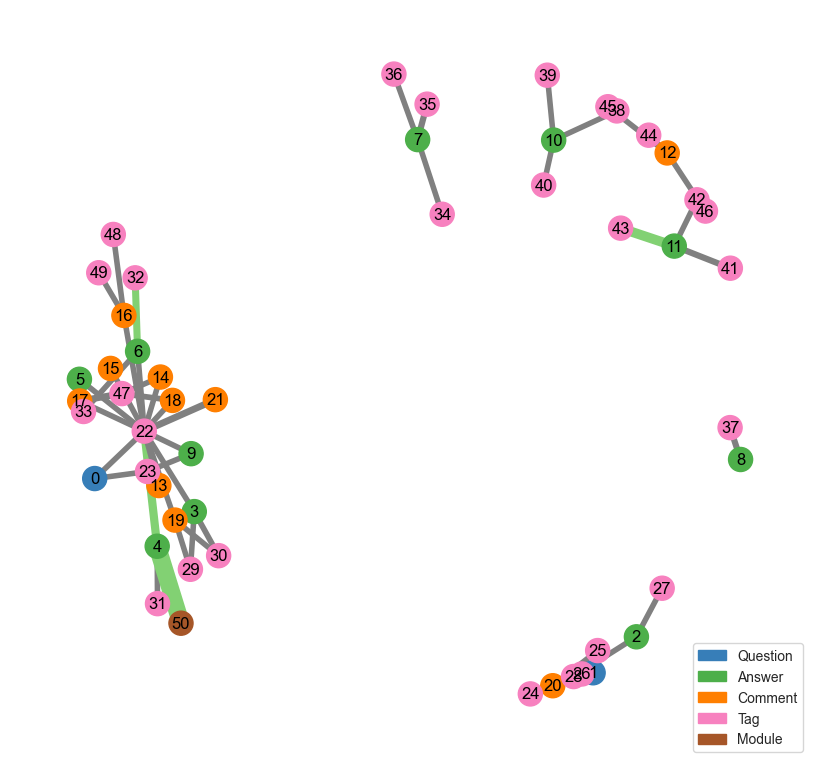

In [157]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='#377EB8', label='Question')
green_patch = mpatches.Patch(color='#4DAF4A', label='Answer')
blue_patch = mpatches.Patch(color='#FF7F00', label='Comment')
pink_patch = mpatches.Patch(color='#F781BF', label='Tag')
brown_patch = mpatches.Patch(color='#A65628', label='Module')


g = visualize_explanation(explanation)
plt.legend(handles=[red_patch, green_patch, blue_patch, pink_patch, brown_patch], loc='lower right')
plt.show()

In [158]:
explanation.prediction

tensor([[0.0194, 0.9806]])

## Bad Topic

In [159]:
bad_explainer_gen = explain_preds(bad_topic_ids[0])

In [160]:
explanation = next(bad_explainer_gen)
#
# pred = torch.argmax(explanation.prediction)
# label = graph.label
# f"Prediction: {pred}, Label: {label.item()}"

Pandas(Index=0, PostId=1628962, PostTypeId=2, AcceptedAnswerId=None, CreationDate='2009-10-27T05:49:26.093', Score=7, ViewCount=None, Body='<p>The line <code>k = k-1</code> does not do what you think. It has no effect. Changing <code>k</code> does not affect the loop. At each iteration, <code>k</code> is assigned to the next element of the range, so any changes you have made to <code>k</code> inside the loop will be overwritten.</p>\n', OwnerUserId=86989.0, LastEditorUserId=nan, LastEditorDisplayName=None, LastEditDate=None, Title=None, Tags=None, AnswerCount=None, CommentCount=1, FavoriteCount=None, CommunityOwnedDate=None, ContentLicense='CC BY-SA 2.5', ParentId=1628949)
5 20 20 54 2 101
TAGS {45: 'django', 46: 'forms', 47: 'class', 48: 'self', 49: 'lambda', 50: 'variadic-functions', 51: 'methods', 52: 'super', 53: 'pass-by-reference', 54: 'pass-by-value', 55: 'parameter-passing', 56: 'java', 57: 'php', 58: 'associative-array', 59: 'ocaml', 60: 'reference', 61: 'go', 62: 'instance', 

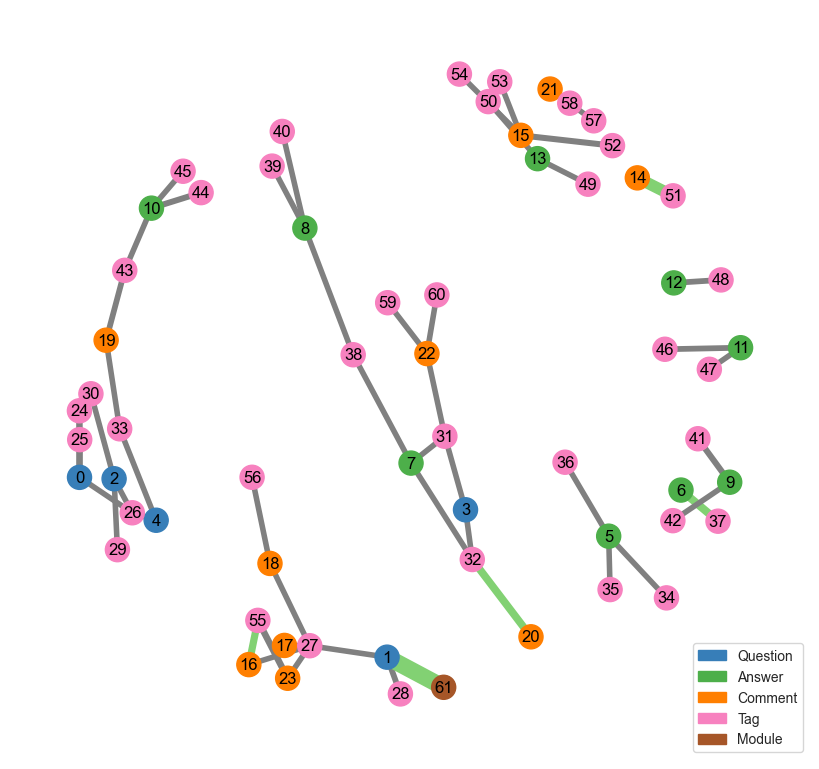

In [161]:

red_patch = mpatches.Patch(color='#377EB8', label='Question')
green_patch = mpatches.Patch(color='#4DAF4A', label='Answer')
blue_patch = mpatches.Patch(color='#FF7F00', label='Comment')
pink_patch = mpatches.Patch(color='#F781BF', label='Tag')
brown_patch = mpatches.Patch(color='#A65628', label='Module')


visualize_explanation(explanation, k=0.55, iterations=40)
plt.legend(handles=[red_patch, green_patch, blue_patch, pink_patch, brown_patch], loc='lower right')
plt.show()

In [162]:
explanation.prediction

tensor([[0.9784, 0.0216]])

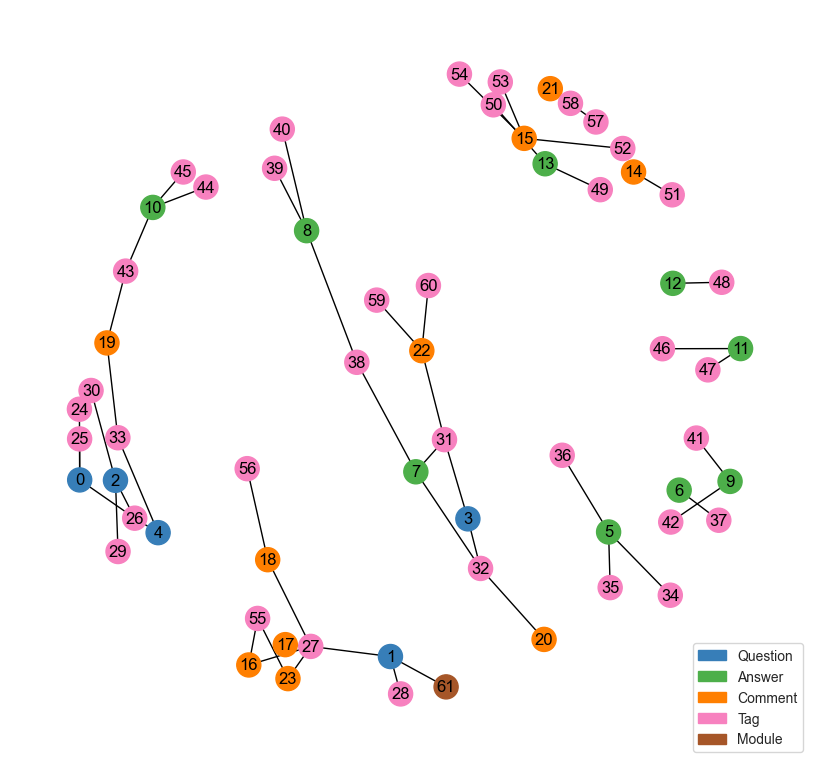

In [169]:
explanation_homog = explanation.to_homogeneous()

# detatch the edge mask
explanation_homog.edge_mask = explanation_homog.edge_mask.detach()
mask = torch.abs(explanation_homog.edge_mask) / torch.max(torch.abs(explanation_homog.edge_mask))
mask = torch.clip(mask, 0.2, 1)
mask = mask.detach().numpy()

# Color nodes by type
node_color = []
cmap = {'question': '#377EB8', 'answer': '#4DAF4A', 'comment': '#FF7F00', 'tag': '#F781BF', 'module': '#A65628'}
for node_type in explanation.x_dict.keys():
    node_color.extend([cmap[node_type]] * explanation.x_dict[node_type].shape[0])

edge_mask_dict = aggregate_edge_directions(mask, explanation_homog)

f = plt.figure(figsize=(8, 7.5))
# set background to white
f.set_facecolor("#00000F")


g = to_networkx(explanation_homog).copy().to_undirected()

# Layout, make nodes more spread out
pos = nx.planar_layout(g)
pos = nx.spring_layout(g, pos=pos, k=0.55, iterations=38)


nx.draw(g, with_labels=True,
        node_color=node_color, pos=pos)


red_patch = mpatches.Patch(color='#377EB8', label='Question')
green_patch = mpatches.Patch(color='#4DAF4A', label='Answer')
blue_patch = mpatches.Patch(color='#FF7F00', label='Comment')
pink_patch = mpatches.Patch(color='#F781BF', label='Tag')
brown_patch = mpatches.Patch(color='#A65628', label='Module')
plt.legend(handles=[red_patch, green_patch, blue_patch, pink_patch, brown_patch], loc='lower right')

f.savefig("UG1.pdf", bbox_inches='tight')